In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ann-pca/resultados_pca_ann.csv
/kaggle/input/datasetmodified/dataset-modificado.csv
/kaggle/input/datosreales/DatosReales.csv


## Visualización de los datos

In [2]:
data=pd.read_csv("/kaggle/input/datasetmodified/dataset-modificado.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


## Separación de los datos

In [3]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

# Conversión del dataset
Transformamos el dataset a array para luego realizar la extracciónde características

In [4]:
array_data_x =  np.array(X)
array_data_y = np.array(Y)

## División de los datos
Se realiza una división de los datos en train y test de forma que quedaron 70% y 30% respectivamente

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,
                                               Y,
                                               test_size=0.3,
                                               random_state=50)

## Función para realizar el Submuestreo de los datos

In [6]:
def balancearClases(balanceador, X_train, y_train):
    Xtrain_new, Ytrain_new=balanceador.fit_resample(X_train,y_train)
    print("Dimensiones")
    print("Xtrain_new: ", Xtrain_new.shape)
    print("Ytrain_new: ", Ytrain_new.shape)
    return Xtrain_new, Ytrain_new

## Entrenamiento del modelo con Oversampling

In [7]:
subsample=RandomOverSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (409248, 16)
Ytrain_new:  (409248,)


In [8]:
hidden_layer_sizes = tuple(10*[100])
model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)

# Función para extraer las características
Esta función realiza la reducción de la dimensionalidad sobre el conjunto de datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

In [9]:
def entrenamiento_pca_ext_caracteristicas(model, n_comp, n_sets, X, Y):
    """
    Argumentos:
        model: modelo a evaluar
        n_comp, int, Número de componentes para reducción
        n_sets,int, Número de particiones
        X: numpy Array de características
        Y: numpy Array  Vector de etiquetas

    Retorna: 
        El valor medio de la medida de rendimiento.
        La desviación estandar de la medida de rendimiento.
        El  valor medio del tiempo de ejecución.
    """  
    #Implemetamos la metodología de validación 
    rendimiento = np.ones(n_sets)
    tiempos = np.ones(n_sets)
    j = 0
    kf = StratifiedKFold(n_splits=n_sets)
    for train_index, test_index in kf.split(X, Y):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]       
        
        # Sejar el mismo nombre del objeto.
        # SOLO vamos a usar el parametro que define
        # el # de componentes.
        pca =PCA(n_components=n_comp)
        # definimos un clasificador.
        clf = model
        # ¿es necesario estandarizacion de datos?
        definicion_pipeline = [
           ('scaler', StandardScaler()), 
           ('pca',pca),
           ('Model', clf)
        ]
        pipeline = Pipeline(definicion_pipeline)
        # para calcular costo computacional
        tiempo_i = time.time()
        pipeline=pipeline.fit(X=X_train, y=y_train)
        tiempo_o = time.time()-tiempo_i
        y_pred=pipeline.predict(X=X_test)
        rendimiento[j] =f1_score(y_true=y_test, y_pred=y_pred)
        tiempos[j] = tiempo_o
        j+=1


    return np.mean(rendimiento), np.std(rendimiento), np.mean(tiempos)

# Realizar experimentos
Se realizan diferentes evaluaciones para validar la efectividad del PCA

In [10]:
def experimentar_PCA(model, n_feats, X, Y):
    """
    Parámetros:
        X (numpy.array), El arreglo numpy de características
        Y (numpy.array), El vector de etiquetas
        n_feats, Vector de números enteros que indica el número de características
                que debe utilizar el modelo
        n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
        - DataFrame con las columnas
    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        rendimiento,rendimiento_std,t_ex = entrenamiento_pca_ext_caracteristicas(model, n_comp=f, n_sets=split_number, X=X ,Y=Y)
        df.loc[idx,'NUM_VAR'] = f
        df.loc[idx,'T_EJECUCION'] = t_ex
        df.loc[idx,'RENDIMIENTO_VALIDACION'] =rendimiento
        df.loc[idx, 'RENDIMIENTO_VALIDACION_STD'] = rendimiento_std
        idx+=1
    return df

# Probando con diferente número de características
Se utiliza el modelo QuadraticDiscriminantAnalysis() para evaluar con 3, 6, 9 y 14 características con la función anterior, además se usan los array creados a partir del dataset

In [11]:
resultados = experimentar_PCA(model, n_feats=[3,6,9,14], X= array_data_x, Y = array_data_y)
resultados

,NUM_VAR,T_EJECUCION,RENDIMIENTO_VALIDACION,RENDIMIENTO_VALIDACION_STD
0,3.0,408.297603,0.000073,0.000146
1,6.0,461.985020,0.000000,0.000000
2,9.0,449.749433,0.082338,0.094976
3,14.0,443.673279,0.058655,0.090022


# Se exporta los resultado a un archivo .csv

In [12]:
resultados.to_csv("resultados_pca_ann.csv", encoding="utf-8")

# Se cargan los resultados

In [13]:
resultados = pd.read_csv("/kaggle/input/ann-pca/resultados_pca_ann.csv")
resultados=resultados.drop(["Unnamed: 0"],axis=1)
resultados

,NUM_VAR,T_EJECUCION,RENDIMIENTO_VALIDACION,RENDIMIENTO_VALIDACION_STD
0,3.0,421.581218,0.000073,0.000146
1,6.0,446.871727,0.000000,0.000000
2,9.0,480.561975,0.077823,0.073846
3,14.0,483.743708,0.058655,0.090022


# Gráficas de rendimiento

## Se grafica el número de variable respecto al rendimiento que tuvieron

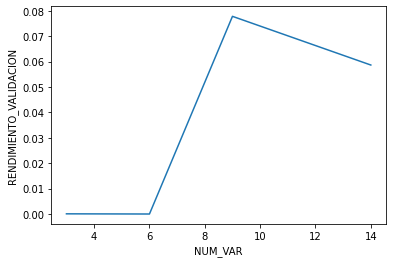

In [14]:
sns.lineplot(data=resultados,x="NUM_VAR",y="RENDIMIENTO_VALIDACION")
plt.show()

## Se grafica el número de variable respecto al tiempo de ejecución que tuvieron

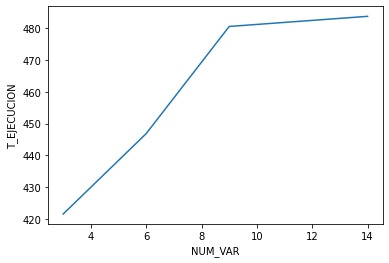

In [15]:
sns.lineplot(data=resultados,x="NUM_VAR",y="T_EJECUCION")
plt.show()

# Ordenar los resultados

## Se ordenan los resultados de forma descendente para ver cuál fue el número de componentes con mejor rendimiento

In [16]:
resultados.sort_values(by ='RENDIMIENTO_VALIDACION', ascending =False)

,NUM_VAR,T_EJECUCION,RENDIMIENTO_VALIDACION,RENDIMIENTO_VALIDACION_STD
2,9.0,480.561975,0.077823,0.073846
3,14.0,483.743708,0.058655,0.090022
0,3.0,421.581218,0.000073,0.000146
1,6.0,446.871727,0.000000,0.000000


## Se ordenan los resultados de forma ascendente para ver cuál fue el número de componentes con menor tiempo de ejecución

In [17]:
resultados.sort_values(by ='T_EJECUCION', ascending =True)

,NUM_VAR,T_EJECUCION,RENDIMIENTO_VALIDACION,RENDIMIENTO_VALIDACION_STD
0,3.0,421.581218,0.000073,0.000146
1,6.0,446.871727,0.000000,0.000000
2,9.0,480.561975,0.077823,0.073846
3,14.0,483.743708,0.058655,0.090022


# Función con el número de componentes seleccionada

Se obtiene el rendimiento de entrenamiento y prueba con el número de componente seleccionada

In [18]:
def entrenamiento_num_caracteristica_seleccionada(model, n_comp, X, Y, Xreal, Yreal):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                               Y,
                                               test_size=0.3,
                                               random_state=50) 

    
    pca =PCA(n_components=n_comp)
    Xreal = pca.fit_transform(Xreal)
    # definimos un clasificador.
    clf = model
    # ¿es necesario estandarizacion de datos?
    definicion_pipeline = [
       ('pca',pca),
       ('Model', clf)
    ]
    pipeline = Pipeline(definicion_pipeline)
    # para calcular costo computacional
    pipeline=pipeline.fit(X=X_train, y=y_train)
    Ypred=pipeline.predict(X_test)
    ## Rendimiento del entrenamiento del modelo
    print("#####################Rendimiento después del entrenamiento#########################")
    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(y_test,Ypred)}')
    print(f'Precission Score: {precision_score(y_test,Ypred)}')
    print(f'Recall Score: {recall_score(y_test,Ypred)}')
    print(f'F1-Score: {f1_score(y_test,Ypred)}')
    cm = confusion_matrix(y_test, Ypred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    print("Pipeline", pipeline.classes_)
    
    print("==============================================")
    y_pred=model.predict(Xreal)
    print("Accuracy:",accuracy_score(Yreal, y_pred))
    print(f'Precission Score: {precision_score(Yreal,y_pred)}')
    print(f'Recall Score: {recall_score(Yreal,y_pred)}')
    print(f'F1-Score: {f1_score(Yreal,y_pred)}')
    cm = confusion_matrix(Yreal, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipeline.classes_)
    disp.plot()

# Se carga la data a probar

In [19]:
data_real=pd.read_csv('/kaggle/input/datosreales/DatosReales.csv')
data_real

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,"19,7",0,0,0,0,0,0,8,10,0,0,5,6,0,0,0
1,0,"22,8",0,0,0,0,0,0,8,10,0,1,5,6,1,0,0
2,1,"28,8",1,0,1,25,28,1,9,20,1,0,3,9,0,1,0
3,0,23,0,0,0,0,0,0,9,10,0,0,6,6,0,0,0
4,1,"32,4",0,1,1,30,15,1,8,18,1,0,4,4,1,1,1
5,0,"22,4",0,1,0,10,7,0,8,15,1,1,4,8,0,0,0
6,0,"21,6",0,0,0,20,8,0,8,10,0,0,3,5,1,0,0
7,0,"29,7",0,0,0,7,0,0,8,10,0,0,3,6,1,0,0
8,1,"30,5",1,1,1,20,0,1,9,12,1,0,2,4,0,1,0
9,1,"34,8",0,1,0,5,3,1,8,21,0,0,3,8,1,0,1


# Se divide la data real

In [20]:
X_real=data_real.iloc[:,1:]
Y_real=data_real.iloc[:,0]
X_real["BMI"] = encoder.fit_transform(X_real["BMI"])

# Se realiza el entrenamiento y validación con el número de componente seleccionado

#####################Rendimiento después del entrenamiento#########################
Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.9151439977485694
Precission Score: 0.0
Recall Score: 0.0
F1-Score: 0.0
Pipeline [0 1]
Accuracy: 0.5333333333333333
Precission Score: 0.0
Recall Score: 0.0
F1-Score: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


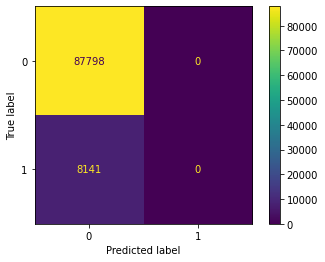

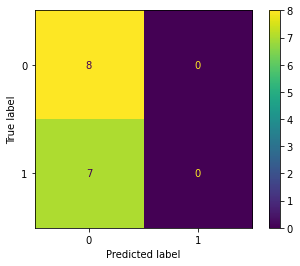

In [21]:
entrenamiento_num_caracteristica_seleccionada(model, n_comp=9, X= array_data_x, Y = array_data_y, Xreal=X_real, Yreal=Y_real)